# Fourier Transforms

In [2]:
%matplotlib inline

import numpy as np
import scipy.fft as ft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
rng = np.random.default_rng()

The Fourier transform (FT) of a quantity $f(t)$ is defined as

$$
\hat{f}(\omega) = F(f(t)) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \mathrm{d}t\, f(t)\, \exp{ \left(-2 \pi i f t \right)}
.
$$

In signal processing, taking the integral from $t = -\infty$ to $t = \infty$ is not practical. Together with a finite sample space $t$, the integral can be turned into a (discrete) sum, giving a Discrete Fourier Transform (DFT)

$$
F(t) = \frac{1}{\sqrt{2\pi}} \sum_{k=0}^{N-1} f(t_k)\, \exp{ \left(-i \omega t_k \right)}
\label{eq:DFT} \tag{1}
,
$$
where the sum iterates over each sample $t_k$ up to the end ($k=N-1$) of the signal.

# Interdependence $\Delta t$, $T$, $\Delta f$, $f_{min}$, $f_{max}$

The highest frequency $f_\mathrm{max}$ (also known as the Nyquist frequency) that can be (reliably) measured within a signal is dependent only on the sampling rate ($1/\Delta t$) of the signal with
$$
    f_\mathrm{max} = \frac{1}{2} f_\mathrm{sampling} = \frac{1}{2} \frac{1}{\Delta t}
    .
$$
Higher frequencies will fall in between two adjacent samples. This means that these frequencies are then 'measured\` with differing phases in such a way that they are 'folded' around the Nyquist frequency and appear as aliased frequencies below it.

Likewise, the lowest frequency depends on the length of the signal $T$, such that over the whole signal one oscillation can be found
$$
    f_\mathrm{min} \sim \frac{1}{T}
    .
$$
Even lower frequencies will no longer be detected as a frequency. Instead, they will introduce a bias for the $0 Hz$ component in the spectrum.


$$
\delta f = \frac{1}{T}
$$

# FTs of ideal signals

In [3]:
def ft_spectrum( signal, sample_rate, fft=None, freq=None, mask_bias=False):
    """Return a FT of $signal$, with corresponding frequencies"""
    n_samples = len(signal)
    real_signal = np.isrealobj(signal)
    
    if fft is None:
        if real_signal:
            fft = ft.rfft
            freq = ft.rfftfreq
        else:
            fft = ft.fft
            freq = ft.fftfreq

    if freq is None:
        freq = ft.fftfreq
    
    spectrum = fft(signal) / sample_rate
    freqs = freq(n_samples, 1/sample_rate)
    
    if not mask_bias:
        return spectrum, freqs
    else:
        return spectrum[1:], freqs[1:]

    
def plot_spectrum( ax, spectrum, freqs, plot_complex=False, plot_power=False, plot_amplitude=None):
    """ Plot a signal's spectrum on an Axis object"""
    plot_amplitude = plot_amplitude or (not plot_power and not plot_complex)
    alpha = 1
    
    ax.set_title("Spectrum")
    ax.set_xlabel("f (Hz)")
    ylabel = ""
    if plot_amplitude or plot_complex:
        ylabel = "Amplitude"
    if plot_power:
        if ylabel:
            ylabel += "|"
        ylabel += "Power"
    ax.set_ylabel(ylabel)

    if plot_complex:
        alpha = 0.5
        ax.plot(freqs, np.real(spectrum), '.-', label='Real', alpha=alpha)
        ax.plot(freqs, np.imag(spectrum), '.-', label='Imag', alpha=alpha)

    if plot_power:
        ax.plot(freqs, np.abs(spectrum)**2, '.-', label='Power', alpha=alpha)
    
    if plot_amplitude:
        ax.plot(freqs, np.abs(spectrum), '.-', label='Abs', alpha=alpha)

    ax.legend()

    return ax


def plot_phase( ax, spectrum, freqs, ylim_epsilon=0.5):
    ax.set_ylabel("Phase")
    ax.set_xlabel("f (Hz)")

    ax.plot(freqs, np.angle(spectrum), '.-')
    ax.set_ylim(-1*np.pi - ylim_epsilon, np.pi + ylim_epsilon)
    
    return ax


def plot_combined_spectrum(spectrum, freqs, 
                           spectrum_kwargs={}, fig=None, gs=None):
    """Plot both the frequencies and phase in one figure."""
    
    # configure plotting layout
    if fig is None:
        fig = plt.figure(figsize=(8, 16))

    if gs is None:
        gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3,1], hspace=0)

    ax1 = fig.add_subplot(gs[:-1, -1])
    ax2 = fig.add_subplot(gs[-1, -1], sharex=ax1)

    axes = np.array([ax1, ax2])
    
    # plot the spectrum 
    plot_spectrum(ax1, spectrum, freqs, **spectrum_kwargs)

    # plot the phase
    plot_phase(ax2, spectrum, freqs)

    ax1.xaxis.tick_top()
    [label.set_visible(False) for label in ax1.get_xticklabels()]
    
    return fig, axes
    

def plot_signal( ax, signal, sample_rate = 1):
    ax.set_title("Signal")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("A(t)")

    ax.plot(np.arange(len(signal)) / sample_rate, signal)
    
    return ax


def plot_signal_and_spectrum( signal, sample_rate, title=None,
                             ft_kwargs = {}, spectrum_kwargs = {}):
    """Plot a signal and its spectrum in one go."""
    fig = plt.figure(figsize=(16, 4))
    
    if title:
        fig.suptitle(title)

    # setup plot layout
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[0].subgridspec(1, 1)
    gs01 = gs0[1].subgridspec(2, 1, height_ratios=[3,1], hspace=0)
      
    # plot the signal
    ax1 = fig.add_subplot(gs00[0, 0])
    plot_signal(ax1, signal)
    
    # plot spectrum
    signal_fft, freqs = ft_spectrum(signal, sample_rate, **ft_kwargs)
    _, (ax2, ax3) = plot_combined_spectrum(signal_fft, freqs, spectrum_kwargs = spectrum_kwargs, fig=fig, gs=gs01)

    # return the axes
    axes = np.array([ax1, ax2, ax3])
    
    return (fig, axes)

In [4]:
sample_rate = 1/1e-3 # s
n_samples = int(1e3)
t = np.arange(n_samples) / sample_rate

### FTs: constant signal

A constant signal (also termed offset or bias) results in only a single component in the Fourier transform, at the zero frequency.

Since often such a component is included in a signal (for example when a signal is not on average zero), it can help to mask out the zero frequency when plotting the spectrum.
Doing this for a constant signal, we get a totally flat spectrum.

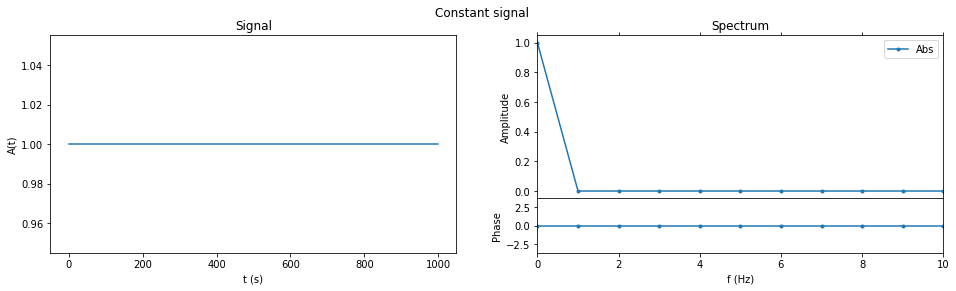

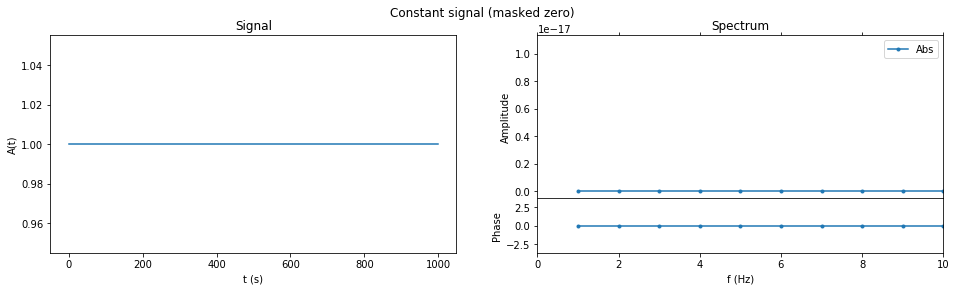

In [4]:
signal_constant = np.ones(int(n_samples))

fig, axes = plot_signal_and_spectrum(signal_constant, sample_rate, "Constant signal")
axes.flat[1].set_xlim(0,10);

fig, axes = plot_signal_and_spectrum(signal_constant, sample_rate, "Constant signal (masked zero)", ft_kwargs={'mask_bias':True})
axes.flat[1].set_xlim(0,10);


### FTs: noise (normal distributed)

A FT of normal distributed noise will not have easily identifiable peaks in the spectrum.
Instead, the spectrum is on average a bit flat, with only low power in any individual peak.

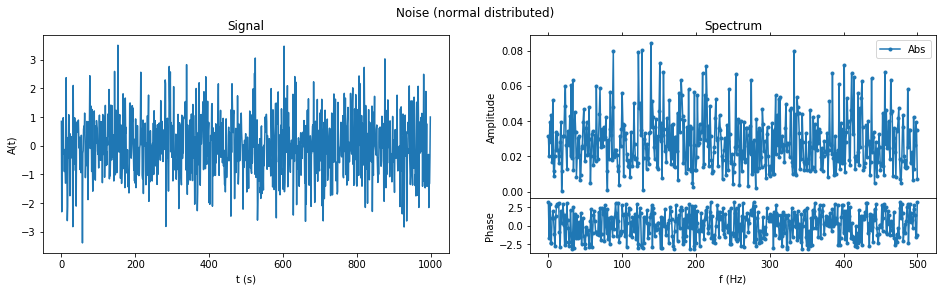

In [5]:
signal_normal_noise = rng.normal(size=n_samples)

plot_signal_and_spectrum(signal_normal_noise, sample_rate, "Noise (normal distributed)");

### FTs: sine wave

(95.0, 105.0)

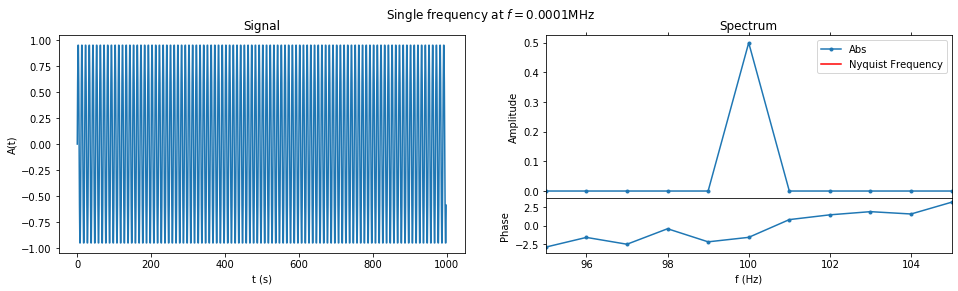

In [6]:
f = 1e2 # Hz
if f > sample_rate/2:
    print("Sampling a frequency above the sample_rate/2 gives problems")

signal_sine = np.sin( 2*np.pi*f*t )

if False:
    # aliased peak
    f_alias = (1.1* sample_rate/2)
    signal_sine += 1/2*np.sin( 2*np.pi* f_alias *t)

fig, axes = plot_signal_and_spectrum(signal_sine, sample_rate, "Single frequency at $f = {:g}$MHz".format(f/10**6))
axes.flat[1].axvline(sample_rate/2, color='r', label='Nyquist Frequency');
axes.flat[1].legend();
axes.flat[1].set_xlim(f-5, f+5)

A sine wave will give very clear peaks at the frequency of the sine wave.

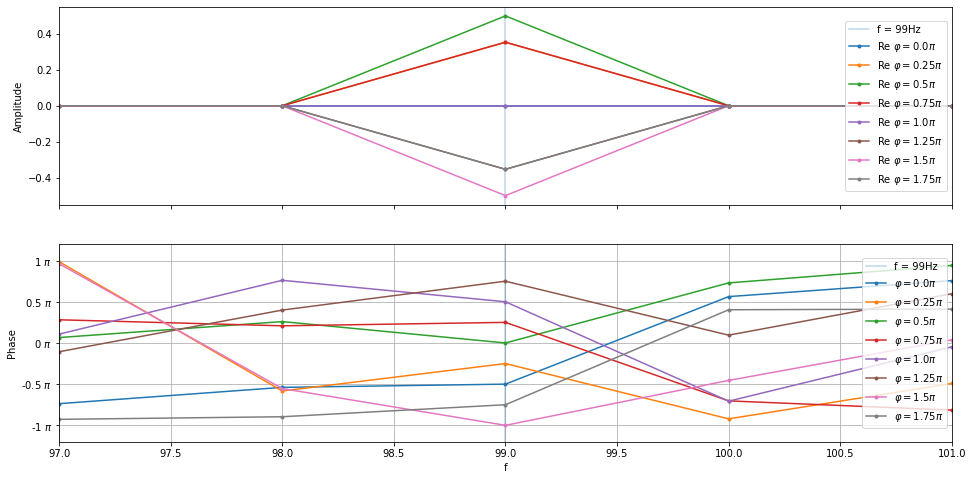

In [7]:
with_spectrum = True
phase_offsets = np.linspace(0, 2*np.pi, 8, endpoint=False) # rad
f = 99 # Hz

if f > sample_rate/2:
    print("Sampling a frequency above the sample_rate/2 gives problems")

if with_spectrum:
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,8))
else:
    fig, ax = plt.subplots(figsize=(16,4))
    axes = np.array([None, ax])
    
if with_spectrum:
    axes[0].set_ylabel("Amplitude")
    axes[0].axvline(f, alpha=0.3, label='f = {:g}Hz'.format(f))

axes[1].axvline(f, alpha=0.3, label='f = {:g}Hz'.format(f))
axes[1].set_ylabel("Phase")
axes[1].set_xlabel("f")
axes[1].set_xlim( f-2, f+2)
axes[1].set_ylim( -1 - 0.2, 1+ 0.2)
axes[1].grid()
axes[1].yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
axes[1].yaxis.set_major_locator(tck.MultipleLocator(base=0.5))

for phase in phase_offsets:
    signal = np.sin( 2*np.pi*f*t + phase )
    
    ft_signal, freqs = ft_spectrum(signal, sample_rate)
    
    if with_spectrum:
        axes[0].plot(freqs, np.real(ft_signal),  '.-', label='Re $\\varphi = {}\\pi$'.format(phase/np.pi))
    
    axes[1].plot(freqs, np.angle(ft_signal)/np.pi, '.-', label='$\\varphi = {}\\pi$'.format(phase/np.pi))

# trigger legends
if with_spectrum:
    axes[0].legend(loc='center right');
axes[1].legend(loc='center right');

plt.show()

For a sine wave, the phase of the spectrum at it's frequency is $\theta( \varphi = 0 ) = - \dfrac{\pi}{2}$.

### FTs: step function

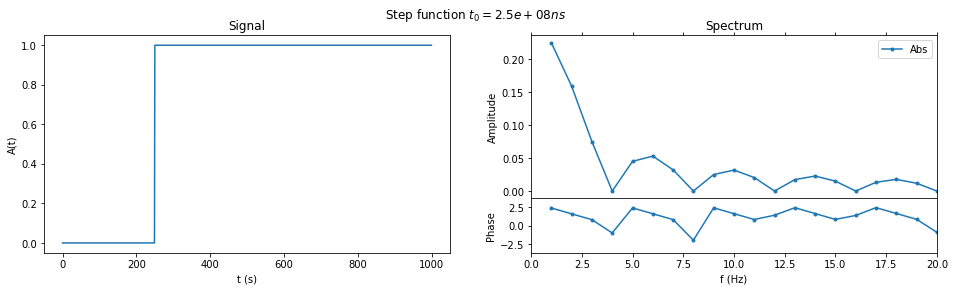

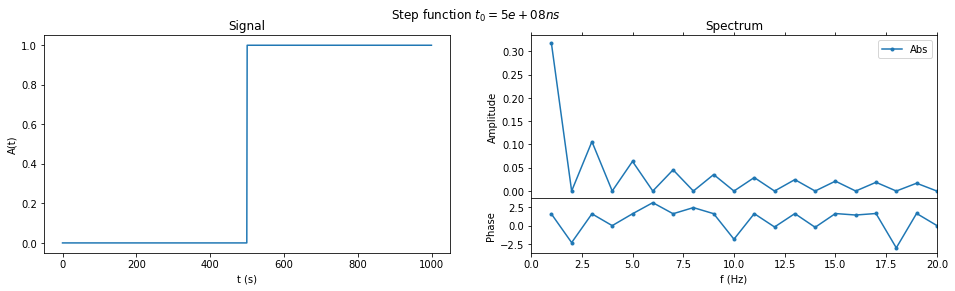

In [8]:
t_0 = t[n_samples//4]
signal_step = np.heaviside(t - t_0, 1)
fig, axes = plot_signal_and_spectrum(signal_step, sample_rate, "Step function $t_0 = {:g}ns$".format(t_0 * 10**9), ft_kwargs={'mask_bias':True});
axes.flat[1].set_xlim(0, 20);

t_0 = t[n_samples//2]
signal_step = np.heaviside(t - t_0, 1)
fig, axes = plot_signal_and_spectrum(signal_step, sample_rate, "Step function $t_0 = {:g}ns$".format(t_0 * 10**9), ft_kwargs={'mask_bias':True});
axes.flat[1].set_xlim(0, 20);

### FTs: delta peak

All frequencies are accounted for with the same amplitude, but the phase will change depending on the position of the delta peak within the signal.

Still, the individual phases are linearly related to their corresponding frequencies.

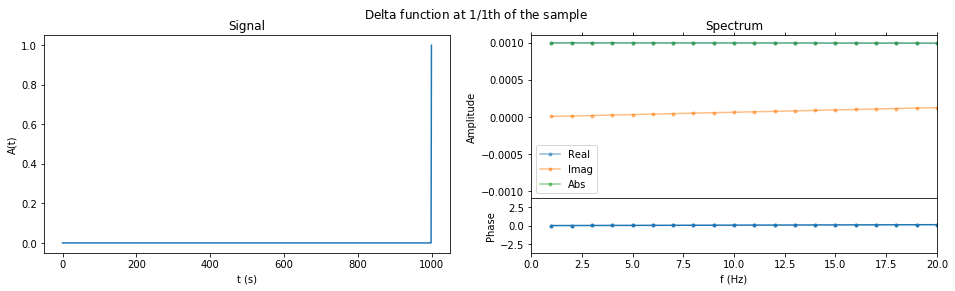

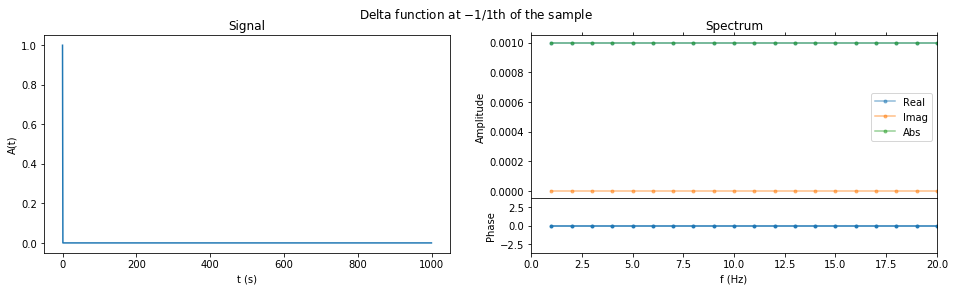

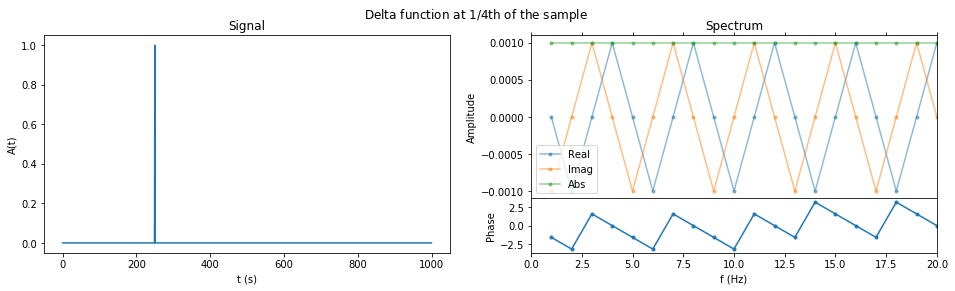

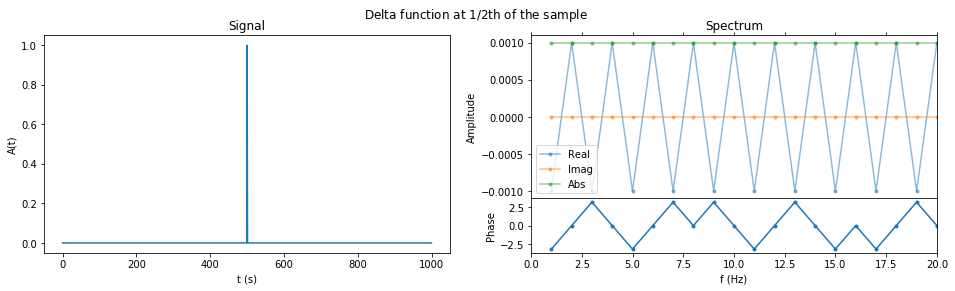

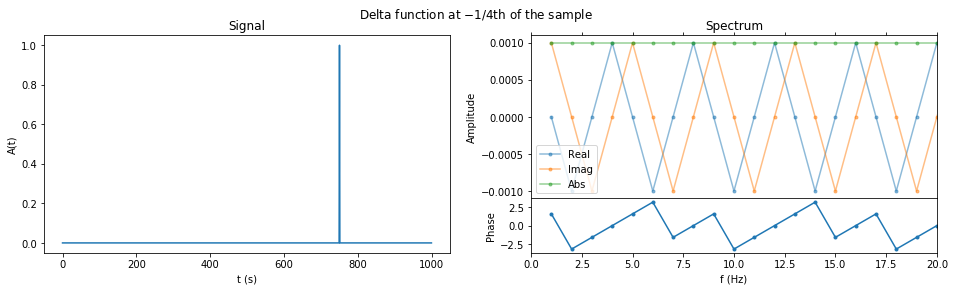

In [10]:

for n in [1, -1, 4, 2, -4]:
    index_t0 = min(n_samples//n, n_samples-1)

    t_0 = t[index_t0]
    signal_step = np.zeros(n_samples)
    signal_step[index_t0] = 1

    fig, axes = plot_signal_and_spectrum(signal_step, sample_rate, ft_kwargs={'mask_bias':True}, spectrum_kwargs={'plot_complex':True, 'plot_amplitude':True});
    fig.suptitle("Delta function at ${}/{}$th of the sample".format(np.sign(n), np.abs(n)))
    axes.flat[1].set_xlim(0, 20);

## FTs: gaussian with sine

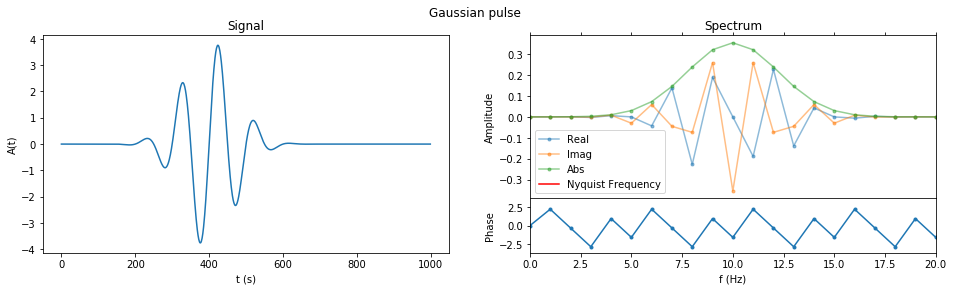

In [9]:
f = 1e1 # Hz
if f > sample_rate/2:
    print("Sampling a frequency above the sample_rate/2 gives problems")

def gaussian(x, mu=0, sigma=1 ):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(- (x-mu)**2 / sigma**2 )

def dgaussian(x, mu=0, sigma=1, dmu=1, dsigma=0):
    return gaussian(x, mu, sigma)   + gaussian(x, mu+dmu, sigma+dsigma)

if not True:
    signal = gaussian(t, t[2*len(t)//5], 100/len(t)) - gaussian(t, t[3*len(t)//5], 100/len(t))
else:
    signal = gaussian(t, t[2*len(t)//5], 100/len(t)) * np.sin(2*np.pi*f*t)

fig, axes = plot_signal_and_spectrum(signal, sample_rate, "Gaussian pulse", spectrum_kwargs={'plot_complex':True, 'plot_amplitude':True})
axes.flat[1].axvline(sample_rate/2, color='r', label='Nyquist Frequency')
axes.flat[2].axvline(sample_rate/2, color='r')
axes.flat[1].legend();

if not True:
    axes.flat[1].set_xlim(0, 20);
else:
    axes.flat[1].set_xlim(max(0, f - max(f/5, 10)), f + max(f/5, 10));
    

#### FTs: delta peak: group velocity

In the above plots, the phases follow

# Peculiarities $F^{-1}( F(A(t)) ) \sim A(t)$

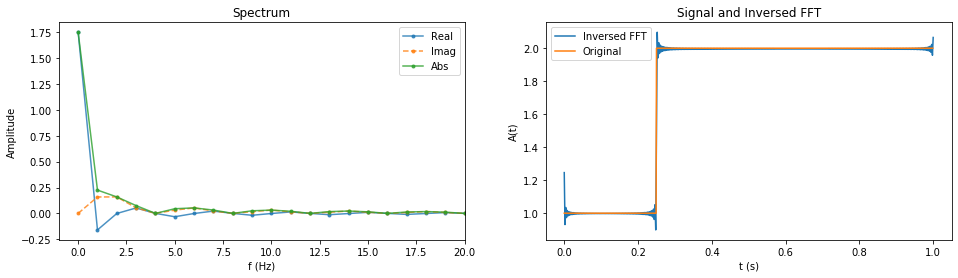

In [10]:
t_0 = t[n_samples//4]
signal_step = np.heaviside(t - t_0, 1) + 1

signal_fft = ft.rfft(signal_step) / sample_rate
signal_ifft = ft.irfft(signal_fft, len(signal_fft))
ft_freqs = ft.rfftfreq(n_samples, 1/sample_rate)


alpha = 0.8
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.set_title("Spectrum")
ax1.set_xlabel("f (Hz)")
ax1.set_ylabel("Amplitude")
ax1.set_xlim(-1,20)
ax1.plot(ft_freqs, np.real(signal_fft), '.-', label='Real', alpha=alpha)
ax1.plot(ft_freqs, np.imag(signal_fft), '.--', label='Imag', alpha=alpha)
ax1.plot(ft_freqs, np.abs(signal_fft),  '.-', label='Abs', alpha=alpha)
ax1.legend()

# Signal and Inversed FFT
ax2.set_title("Signal and Inversed FFT")
ax2.set_xlabel("t (s)")
ax2.set_ylabel("A(t)")
ax2.plot(np.arange(len(signal_ifft)) / sample_rate * 2, np.abs(signal_ifft)*sample_rate/2, label="Inversed FFT")
ax2.plot(np.arange(len(signal_step)) / sample_rate, signal_step, label="Original")
ax2.legend()

if False:
    ax2.set_xlim(t_0*(1-0.2), t_0*(1+0.2))

plt.show();


# DFT

A naive implementation of a DFT is simple to setup by implementing Eq. (1)

$$
\hat{f}(\omega) = F(t) = \frac{1}{\sqrt{2\pi}} \sum_{k=0}^{N-1} f(t_k)\, \exp{ \left(-i \omega t_k \right)}
.
$$

In [11]:
def naive_DFT( signal ):
    """
    Calculate DFT in a naive way, returns a complex DFT.
    """

    N = np.size(signal)

    x_k = 2*np.pi/N*np.arange(N)
    ft = np.zeros(N, dtype=np.complex128)
    for j in range(N):
        ft[j] = np.dot(signal, np.exp(- 1j * j * x_k ))

    return ft

### DFT: Cooley and Tukey (or Divide and Conquer)

A smarter DFT (Cooley and Tukey) can be implemented by splitting the sum in Eq. (1) into two parts: $k$ even and $k$ odd.

With a uniform sample space $t$, the label $t_k$ can be rewritten to $t_k = k \Delta t = $.

This gives
$$
F(t) = 
    \frac{1}{\sqrt{2\pi}} \sum_{k=0}^{N/2-1} f(t_{2k})\, \exp{ \left(-i \omega \, t_{2k} \right)}
    +
    \frac{1}{\sqrt{2\pi}} \sum_{k=0}^{N/2-1} f(t_{2k+1})\, \exp{ \left(-i \omega \, t_{2k+1} \right)}
    \\
    =
    \frac{1}{\sqrt{2\pi}} \sum_{k=0}^{N/2-1} f(t_{2k})\, \exp{ \left(-i \omega \, 2k \Delta t \right)}
    +
    \frac{1}{\sqrt{2\pi}} \sum_{k=0}^{N/2-1} f(t_{2k+1})\, \exp{ \left(-i \omega \, 2k \Delta t \right)}\exp{ \left(-i \omega \, \Delta t \right)}
    \\
    =
    \frac{1}{\sqrt{2\pi}} \sum_{k=0}^{N/2-1} f(t_{2k})\, \exp{ \left(-i \omega \, 2k \Delta t \right)}
    +
    \frac{\exp{ \left(-i \omega \, \Delta t \right)} }{\sqrt{2\pi}} \sum_{k=0}^{N/2-1} f(t_{2k+1})\, \exp{ \left(-i \omega \, 2k \Delta t \right)}
    \\
    =
    F(t_{even}) + F(t_{odd}) \exp{ \left(-i \omega \, \Delta t \right)}
$$

In [12]:
def cooley_tukey_DFT( signal ):
    """
    Calculate a DFT according to the Cooley and Tukey algorithm (radix-2)
    also known as Divide and Conquer.
    
    It divides the terms into 2 streams with odd and even index.
    """
    radix = 2

    N = np.size(signal)
    
    if N <= radix:
        return naive_DFT(signal)
    
    if N % radix > 0:
        raise ValueError("Provide a signal with  N%{radix} == 0 values.".format(radix=radix))
    
    # divide and conquer
    DFT_even = cooley_tukey_DFT(signal[::radix])
    DFT_odd  = cooley_tukey_DFT(signal[1::radix])
    
    phase_terms = np.exp( -2j * np.pi * np.arange(0, N) / N )
    
    return np.tile(DFT_even, 2) + np.tile(DFT_odd,2) * phase_terms


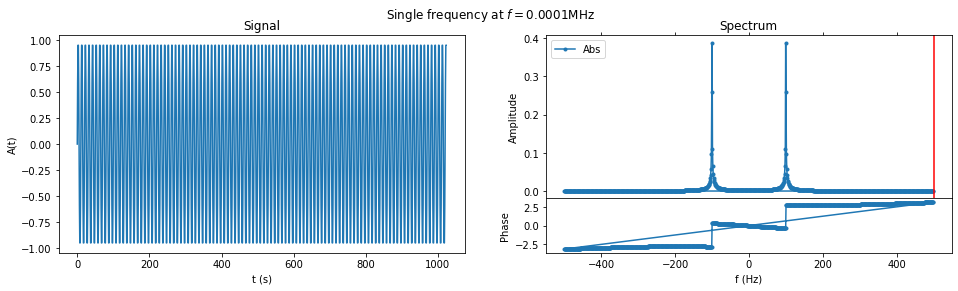

In [13]:
dft_sample_rate = 1/1e-3 # s
dft_n_samples = 2**10
dft_t = np.arange(dft_n_samples) / dft_sample_rate

f = 1e2 # Hz
if f > dft_sample_rate/2:
    print("Sampling a frequency above the sample_rate/2 gives problems")

signal_sine = np.sin( 2*np.pi*f*dft_t )

fig, axes = plot_signal_and_spectrum(signal_sine, dft_sample_rate, "Single frequency at $f = {:g}$MHz".format(f/10**6), ft_kwargs={'fft': cooley_tukey_DFT})
axes.flat[1].axvline(dft_sample_rate/2, color='r', label='Nyquist Frequency');